In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import importlib
import sys
import os

sys.path.append(os.path.abspath(os.path.join('src', 'utils')))

import data_cleaning
import plotting
import data_utils

importlib.reload(data_cleaning)
importlib.reload(plotting)
importlib.reload(data_utils)

from data_cleaning import *
from plotting import *
from data_utils import *

warnings.filterwarnings("ignore")

# Data Loading and Data Cleaning

In [52]:
# Data Loading
embeddings_distilbert = pd.read_csv('data/embeddings_distilbert_correct.csv')
embeddings_bert = pd.read_csv('data/embeddings_bert_correct.csv')
embeddings_longformer = pd.read_csv('data/embeddings_longformer_correct.csv')
fred_df = pd.read_csv("data/current_month.csv")

FRED dataset contains our response variables. The dataset requires its columns to be transformed according to functions specified in the documentation. Once performed the transformations, the first three rows can be skipped, containing the information about transformations and NaN values. 
Finally, we compute the S&P500 return.

In [53]:
# Transform columns
fred_df = apply_tranformations(fred_df, skip_cols={'sasdate'})
fred_df = fred_df.iloc[3:]

# Change to the right data types
fred_df['sasdate'] = pd.to_datetime(fred_df['sasdate'])
fred_df['S&P500 ret'] = fred_df['S&P 500'].pct_change()
fred_df = fred_df.drop(fred_df.index[0])
fred_df = fred_df.reset_index(drop=True)

# Create month and year
if 'month' not in fred_df.columns:
    fred_df['month'] = fred_df['sasdate'].apply(lambda x: x.month)
if 'year' not in fred_df.columns:
    fred_df['year'] = fred_df['sasdate'].apply(lambda x: x.year)

We can now build the response variable for the models we are going to use.

In [54]:
# Consider only months used as outputs
Y = fred_df[((fred_df['month']==1)+(fred_df['month']==4)+(fred_df['month']==7)+(fred_df['month']==10))*(fred_df['year']>=2005)*(fred_df['year']<=2024)]

# Create the 'quarter and year' column
Y['quarter and year'] = Y.apply(
    lambda row: f"{row['year']} Q{get_quarter(row['month'])}", axis=1
)
Y = Y.sort_values(by='quarter and year', ascending=True)
Y['quarter and year'] = Y['quarter and year'].shift(1)

Y = Y.iloc[1:,:]

Now, we suitably manipuate the datasets containing the embeddings to feed them to the models.

In [55]:
# Extract quarters

embeddings_distilbert['embeddings'] = embeddings_distilbert['embeddings'].apply(lambda x: change_format(x))
embeddings_distilbert['quarter and year'] = embeddings_distilbert.apply(
    lambda row: f"{row['year']} Q{get_quarter(row['month'])}", axis=1
)

embeddings_bert['embeddings'] = embeddings_bert['embeddings'].apply(lambda x: change_format(x))
embeddings_bert['quarter and year'] = embeddings_bert.apply(
    lambda row: f"{row['year']} Q{get_quarter(row['month'])}", axis=1
)

embeddings_longformer['embeddings'] = embeddings_longformer['embeddings'].apply(lambda x: change_format(x))
embeddings_longformer['quarter and year'] = embeddings_longformer.apply(
    lambda row: f"{row['year']} Q{get_quarter(row['month'])}", axis=1
)

# 1) Baseline: Plain Linear Regression

The most simple idea we could use is simply perform a linear regression on the embeddings provided by DistilBERT model. 

In particular, the idea is to adopt a rolling window approach, where at each time-window we train the model on five years and three quarters, validate on the last quarter of the sixth year, and test on the quarter following these six years. To be precise, what we do is, for every quarter, extract the component-wise average among all embeddings of each quarter, and use these averages as input for the regression model.

In [56]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
torch.use_deterministic_algorithms(False)

In [57]:
# Input parameters
N = 500
start_month = 1
start_year = 2009
end_month = 6
end_year = 2020
max_epochs = 30
bs = 1
epochs_limit = 3
tol = 1e-4
output_size = 1
by = 'mean'   
num_components_PCA = [10]
num_components = [1] if by=='mean' else num_components_PCA
output_columns = ['S&P500 ret']
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = 'linear'

# Validation parameters
num_hidden_layers = [3]
hidden_sizes = [128]
learning_rates = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 5e-3]

# Initialization of variables
Y_pred_list = []
train_losses_list = []
val_losses_list = []
test_losses_list = []
Y_test_list = []
similarities_list = []
failed_idxs_list = []
eigenvalues_list = []

# Perform rolling window
for n_comp in num_components:
    input_size = 768*n_comp
    Y_pred, test_losses, train_losses, val_losses, Y_test, similarities, eigenvalues = rolling_window(embeddings_distilbert, Y, N, start_month, start_year, end_month, end_year, 
                                                            max_epochs, bs, output_columns,  learning_rates, hidden_sizes, num_hidden_layers, 
                                                            tol, input_size, output_size, criterion, device, epochs_limit, by, n_comp, model_type)
    Y_pred_list.append(Y_pred)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    test_losses_list.append(test_losses)
    Y_test_list.append(Y_test)
    similarities_list.append(similarities)
    eigenvalues_list.append(eigenvalues)

Training period: 1/2009 - 9/2014
Validation period: 10/2014 - 12/2014
Test period: 1/2015 - 3/2015
Loss for validation: 6.452762590924976e-08 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.001
Training period: 4/2009 - 12/2014
Validation period: 1/2015 - 3/2015
Test period: 4/2015 - 6/2015
Loss for validation: 4.034600351587869e-05 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.0005
Training period: 7/2009 - 3/2015
Validation period: 4/2015 - 6/2015
Test period: 7/2015 - 9/2015
Loss for validation: 0.004652520641684532 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.003
Training period: 10/2009 - 6/2015
Validation period: 7/2015 - 9/2015
Test period: 10/2015 - 12/2015
Loss for validation: 0.007105486933141947 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.0001
Training period: 1/2010 - 9/2015
Validation period: 10/2015 - 12/2015
Test period:

In the following, we see how the loss behaves during training: as it should, it starts from bigger values and decreases until reaching a stable value.

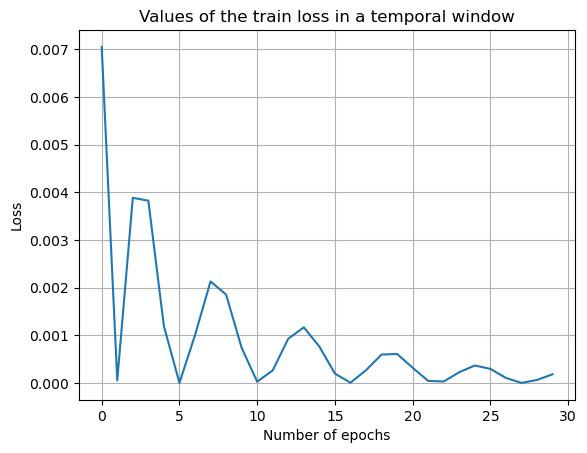

In [58]:
plt.plot(range(len(train_losses_list[0][19])), train_losses_list[0][19])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Values of the train loss in a temporal window')
plt.grid(True)

In [59]:
# Display results
if by=='mean':
    for i, _ in enumerate(num_components):
        print("R squared:", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE:", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE:", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))
elif by=='PCA':
    for i, _ in enumerate(num_components):
        print("R squared for number of PCA components", num_components[i],":", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE for number of PCA components", num_components[i],":", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE for number of PCA components", num_components[i],":", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))

R squared: -0.5719039372225565
MSE: 0.0011963147434173463
RMSE: 0.034587783152687686


Now, let us visually inspect the behaviour of the S&P500 returns with their predicted values. Notice how the predictions are not very accurate, and we need some better models to obtain better results.

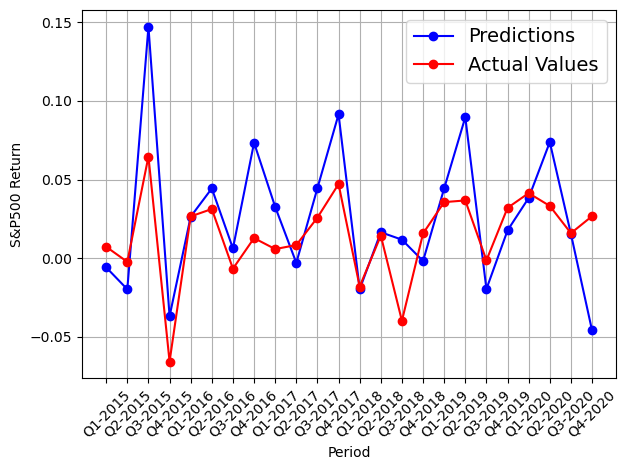

In [60]:
# Display predictions vs true values
plot_returns(Y_pred_list, Y_test_list, 'mean')

# 2) Neural Network with DistilBERT Embeddings

Let us now proceed with a more convoluted model. We will use a Neural Network with three hidden layers, which takes as inputs the averages of the embeddings provided by DistilBERT for each quarter.

In [61]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
torch.use_deterministic_algorithms(False)

In [62]:
# Input parameters
N = 500
start_month = 1
start_year = 2009
end_month = 6
end_year = 2020
max_epochs = 30
bs = 1
epochs_limit = 3
tol = 1e-4
output_size = 1
by = 'mean'   
num_components_PCA = [10]
num_components = [1] if by=='mean' else num_components_PCA
output_columns = ['S&P500 ret']
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validation parameters
num_hidden_layers = [3]
hidden_sizes = [128,256,512,1024]
learning_rates = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 5e-3]

# Initialization of variables
Y_pred_list = []
train_losses_list_distilbert = []
val_losses_list_distilbert = []
test_losses_list_distilbert = []
Y_test_list = []
similarities_list_distilbert = []
failed_idxs_list = []
eigenvalues_list_distilbert = []

# Perform rolling window
for n_comp in num_components:
    input_size = 768*n_comp
    Y_pred, test_losses_distilbert, train_losses_distilbert, val_losses_distilbert, Y_test, similarities_distilbert, eigenvalues_distilbert = rolling_window(embeddings_distilbert, Y, N, start_month, start_year, end_month, end_year, 
                                                            max_epochs, bs, output_columns,  learning_rates, hidden_sizes, num_hidden_layers, 
                                                            tol, input_size, output_size, criterion, device, epochs_limit, by, n_comp)
    Y_pred_list.append(Y_pred)
    train_losses_list_distilbert.append(train_losses_distilbert)
    val_losses_list_distilbert.append(val_losses_distilbert)
    test_losses_list_distilbert.append(test_losses_distilbert)
    Y_test_list.append(Y_test)
    similarities_list_distilbert.append(similarities_distilbert)
    eigenvalues_list_distilbert.append(eigenvalues_distilbert)

Training period: 1/2009 - 9/2014
Validation period: 10/2014 - 12/2014
Test period: 1/2015 - 3/2015
Loss for validation: 2.1257579646771774e-05 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.0003
Training period: 4/2009 - 12/2014
Validation period: 1/2015 - 3/2015
Test period: 4/2015 - 6/2015
Loss for validation: 3.621908888362668e-07 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.005
Training period: 7/2009 - 3/2015
Validation period: 4/2015 - 6/2015
Test period: 7/2015 - 9/2015
Loss for validation: 0.0023707286454737186 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.005
Training period: 10/2009 - 6/2015
Validation period: 7/2015 - 9/2015
Test period: 10/2015 - 12/2015
Loss for validation: 1.178170623461483e-05 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.0001
Training period: 1/2010 - 9/2015
Validation period: 10/2015 - 12/2015
Test peri

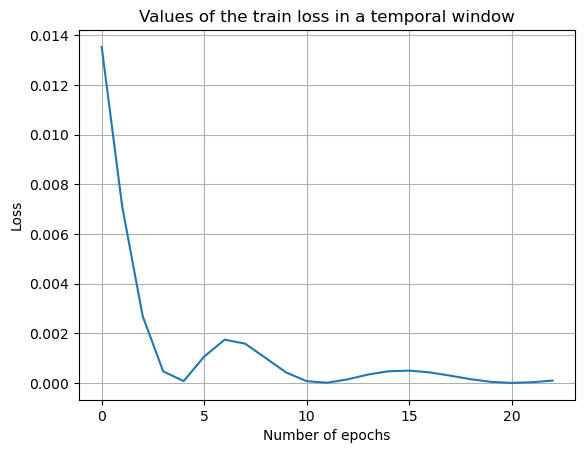

In [64]:
plt.plot(range(len(train_losses_list_distilbert[0][19])), train_losses_list_distilbert[0][19])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Values of the train loss in a temporal window')
plt.grid(True)

In [65]:
# Display results
if by=='mean':
    for i, _ in enumerate(num_components):
        print("R squared:", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE:", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE:", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))
elif by=='PCA':
    for i, _ in enumerate(num_components):
        print("R squared for number of PCA components", num_components[i],":", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE for number of PCA components", num_components[i],":", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE for number of PCA components", num_components[i],":", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))

R squared: -0.3850812964340058
MSE: 0.0010541313222253285
RMSE: 0.032467388595717524


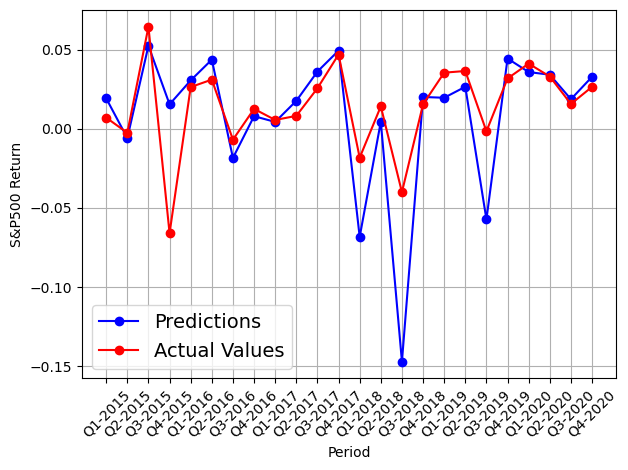

In [66]:
# Display predictions vs true values
plot_returns(Y_pred_list, Y_test_list, by)

We notice a big improvement with respect to the baseline, both in terms of R-squared and MSE on the test set. Most probably, this is due to the fact that we adopted a more complex model, able to catch some nonlineary in the underlying distribution of the response variable due to the presence of ReLu layers.

Now, we try to see whether we can get better results by using the same model on a set of embeddings obtained through BERT, a more complex transformer than DistilBERT.

# 3) Neural Network with BERT Embeddings

In [67]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
torch.use_deterministic_algorithms(False)

In [68]:
# Input parameters
N = 500
start_month = 1
start_year = 2009
end_month = 6
end_year = 2020
max_epochs = 30
bs = 1
epochs_limit = 3
tol = 1e-4
output_size = 1
by = 'mean'   
num_components_PCA = [10]
num_components = [1] if by=='mean' else num_components_PCA
output_columns = ['S&P500 ret']
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validation parameters
num_hidden_layers = [3]
hidden_sizes = [128,256,512,1024]
learning_rates = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 5e-3]

# Initialization of variables
Y_pred_list = []
train_losses_list = []
val_losses_list = []
test_losses_list = []
Y_test_list = []
similarities_list = []
failed_idxs_list = []
eigenvalues_list = []

# Perform rolling window
for n_comp in num_components:
    input_size = 768*n_comp
    Y_pred, test_losses, train_losses, val_losses, Y_test, similarities, eigenvalues = rolling_window(embeddings_bert, Y, N, start_month, start_year, end_month, end_year, 
                                                            max_epochs, bs, output_columns,  learning_rates, hidden_sizes, num_hidden_layers, 
                                                            tol, input_size, output_size, criterion, device, epochs_limit, by, n_comp)
    Y_pred_list.append(Y_pred)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    test_losses_list.append(test_losses)
    Y_test_list.append(Y_test)
    similarities_list.append(similarities)
    eigenvalues_list.append(eigenvalues)

Training period: 1/2009 - 9/2014
Validation period: 10/2014 - 12/2014
Test period: 1/2015 - 3/2015
Loss for validation: 8.74089528224431e-05 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.005
Training period: 4/2009 - 12/2014
Validation period: 1/2015 - 3/2015
Test period: 4/2015 - 6/2015
Loss for validation: 4.037681478052946e-08 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.0003
Training period: 7/2009 - 3/2015
Validation period: 4/2015 - 6/2015
Test period: 7/2015 - 9/2015
Loss for validation: 0.002823589602485299 obtained with:
Best number of layers: 3
Best hidden size: 1024
Best learning rate: 0.005
Training period: 10/2009 - 6/2015
Validation period: 7/2015 - 9/2015
Test period: 10/2015 - 12/2015
Loss for validation: 0.008871657773852348 obtained with:
Best number of layers: 3
Best hidden size: 128
Best learning rate: 0.0003
Training period: 1/2010 - 9/2015
Validation period: 10/2015 - 12/2015
Test period:

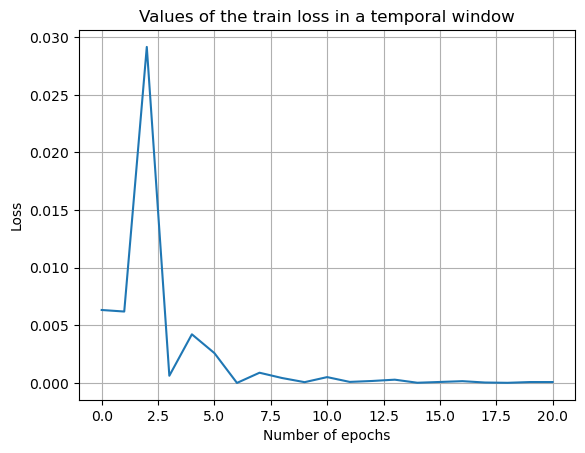

In [69]:
plt.plot(range(len(train_losses_list[0][19])), train_losses_list[0][19])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Values of the train loss in a temporal window')
plt.grid(True)

In [70]:
# Display results
if by=='mean':
    for i, _ in enumerate(num_components):
        print("R squared:", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE:", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE:", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))
elif by=='PCA':
    for i, _ in enumerate(num_components):
        print("R squared for number of PCA components", num_components[i],":", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE for number of PCA components", num_components[i],":", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("MSE for number of PCA components", num_components[i],":", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))

R squared: 0.10522013959844212
MSE: 0.0006809820331658993
RMSE: 0.026095632453839845


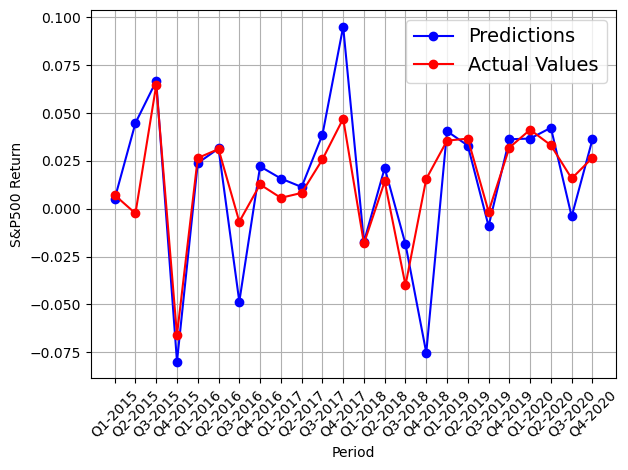

In [71]:
# Display predictions vs true values
plot_returns(Y_pred_list, Y_test_list, 'mean')

# 4) Neural Network with Longformer Embeddings

In [72]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
torch.use_deterministic_algorithms(False)

In [73]:
# Input parameters
N = 500
start_month = 1
start_year = 2009
end_month = 6
end_year = 2020
max_epochs = 30
bs = 1
epochs_limit = 3
tol = 1e-4
output_size = 1
by = 'mean'   
num_components_PCA = [10]
num_components = [1] if by=='mean' else num_components_PCA
output_columns = ['S&P500 ret']
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validation parameters
num_hidden_layers = [3]
hidden_sizes = [128,256,512,1024]
learning_rates = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 5e-3]

# Initialization of variables
Y_pred_list = []
train_losses_list = []
val_losses_list = []
test_losses_list = []
Y_test_list = []
similarities_list = []
failed_idxs_list = []
eigenvalues_list = []

# Perform rolling window
for n_comp in num_components:
    input_size = 768*n_comp
    Y_pred, test_losses, train_losses, val_losses, Y_test, similarities, eigenvalues = rolling_window(embeddings_longformer, Y, N, start_month, start_year, end_month, end_year, 
                                                            max_epochs, bs, output_columns,  learning_rates, hidden_sizes, num_hidden_layers, 
                                                            tol, input_size, output_size, criterion, device, epochs_limit, by, n_comp)
    Y_pred_list.append(Y_pred)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    test_losses_list.append(test_losses)
    Y_test_list.append(Y_test)
    similarities_list.append(similarities)
    eigenvalues_list.append(eigenvalues)

Training period: 1/2009 - 9/2014
Validation period: 10/2014 - 12/2014
Test period: 1/2015 - 3/2015
Loss for validation: 2.8660273528657854e-05 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.0003
Training period: 4/2009 - 12/2014
Validation period: 1/2015 - 3/2015
Test period: 4/2015 - 6/2015
Loss for validation: 1.0926602271865704e-06 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.003
Training period: 7/2009 - 3/2015
Validation period: 4/2015 - 6/2015
Test period: 7/2015 - 9/2015
Loss for validation: 4.309321411710698e-06 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.0001
Training period: 10/2009 - 6/2015
Validation period: 7/2015 - 9/2015
Test period: 10/2015 - 12/2015
Loss for validation: 0.0008541236747987568 obtained with:
Best number of layers: 3
Best hidden size: 256
Best learning rate: 0.0001
Training period: 1/2010 - 9/2015
Validation period: 10/2015 - 12/2015
Test pe

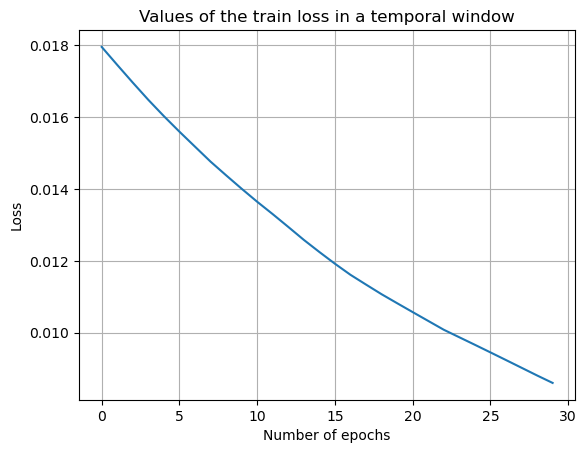

In [74]:
plt.plot(range(len(train_losses_list[0][19])), train_losses_list[0][19])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Values of the train loss in a temporal window')
plt.grid(True)

In [75]:
# Display results
if by=='mean':
    for i, _ in enumerate(num_components):
        print("R squared:", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE:", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE:", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))
elif by=='PCA':
    for i, _ in enumerate(num_components):
        print("R squared for number of PCA components", num_components[i],":", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE for number of PCA components", num_components[i],":", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("MSE for number of PCA components", num_components[i],":", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))

R squared: 0.26624942015096276
MSE: 0.0005584289318693576
RMSE: 0.02363110094492759


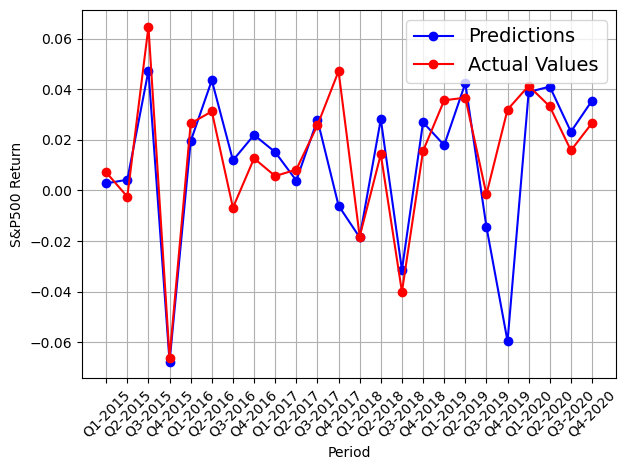

In [76]:
# Display predictions vs true values
plot_returns(Y_pred_list, Y_test_list, 'mean')

# 5) Neural Network with BERT Embeddings and PCA Aggregation

In [77]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
torch.use_deterministic_algorithms(False)

In [78]:
# Input parameters
N = 500
start_month = 1
start_year = 2009
end_month = 6
end_year = 2020
max_epochs = 30
bs = 1
epochs_limit = 3
tol = 1e-4
output_size = 1
by = 'PCA'   
num_components_PCA = [1, 5, 10] 
num_components = [1] if by=='mean' else num_components_PCA
output_columns = ['S&P500 ret']
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validation parameters
num_hidden_layers = [3]
learning_rates = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 5e-3]

# Initialization of variables
Y_pred_list = []
train_losses_list = []
val_losses_list = []
test_losses_list = []
Y_test_list = []
similarities_list = []
failed_idxs_list = []
eigenvalues_list = []

# Perform rolling window
for n_comp in num_components:
    hidden_sizes = [768//2,768//4,768]
    input_size = 768*n_comp
    Y_pred, test_losses, train_losses, val_losses, Y_test, similarities, eigenvalues = rolling_window(embeddings_longformer, Y, N, start_month, start_year, end_month, end_year, 
                                                            max_epochs, bs, output_columns,  learning_rates, hidden_sizes, num_hidden_layers, 
                                                            tol, input_size, output_size, criterion, device, epochs_limit, by, n_comp)
    Y_pred_list.append(Y_pred)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    test_losses_list.append(test_losses)
    Y_test_list.append(Y_test)
    similarities_list.append(similarities)
    eigenvalues_list.append(eigenvalues)

Training period: 1/2009 - 9/2014
Validation period: 10/2014 - 12/2014
Test period: 1/2015 - 3/2015
Loss for validation: 3.3221224384760717e-06 obtained with:
Best number of layers: 3
Best hidden size: 192
Best learning rate: 0.005
Training period: 4/2009 - 12/2014
Validation period: 1/2015 - 3/2015
Test period: 4/2015 - 6/2015
Loss for validation: 2.399933009655797e-06 obtained with:
Best number of layers: 3
Best hidden size: 192
Best learning rate: 0.0005
Training period: 7/2009 - 3/2015
Validation period: 4/2015 - 6/2015
Test period: 7/2015 - 9/2015
Loss for validation: 0.0025217020884156227 obtained with:
Best number of layers: 3
Best hidden size: 192
Best learning rate: 0.005
Training period: 10/2009 - 6/2015
Validation period: 7/2015 - 9/2015
Test period: 10/2015 - 12/2015
Loss for validation: 0.014469890855252743 obtained with:
Best number of layers: 3
Best hidden size: 192
Best learning rate: 0.0005
Training period: 1/2010 - 9/2015
Validation period: 10/2015 - 12/2015
Test perio

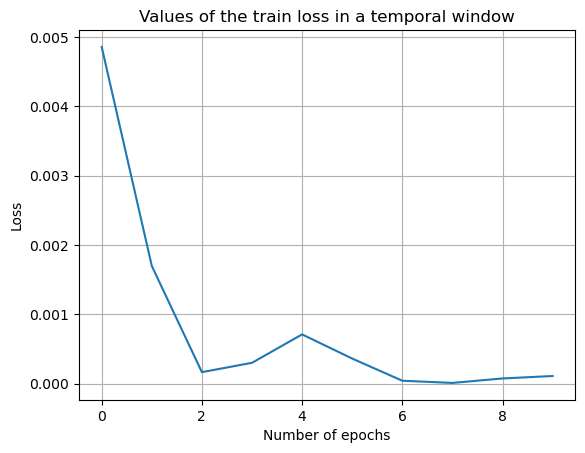

In [ ]:
plt.plot(range(len(train_losses_list[0][19])), train_losses_list[0][19])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Values of the train loss in a temporal window')
plt.grid(True)

For each of the used number of PCA components, we display R-squared, MSE and RMSE computed on the test set for every window.

Notice that the model seems to perform better and better as the number of components increases (i.e. the explained variance in the dataset increases, as shown after).

In [45]:
# Display results
if by=='mean':
    for i, _ in enumerate(num_components):
        print("R squared:", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE:", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE:", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))
elif by=='PCA':
    for i, _ in enumerate(num_components):
        print("R squared for number of PCA components", num_components[i],":", r2_score(Y_test_list[i], Y_pred_list[i]))
        print("MSE for number of PCA components", num_components[i],":", mean_squared_error(Y_pred_list[i], Y_test_list[i]))
        print("RMSE for number of PCA components", num_components[i],":", np.sqrt(mean_squared_error(Y_pred_list[i], Y_test_list[i])))

R squared for number of PCA components 1 : -0.7534389711265868
MSE for number of PCA components 1 : 0.0013344739733572423
RMSE for number of PCA components 1 : 0.03653045268481137
R squared for number of PCA components 5 : 0.2425888333087206
MSE for number of PCA components 5 : 0.0005764360811658309
RMSE for number of PCA components 5 : 0.02400908330540404
R squared for number of PCA components 10 : 0.4130021739891869
MSE for number of PCA components 10 : 0.00044674113791677637
RMSE for number of PCA components 10 : 0.02113625174709973


Naturally, the average amount of explained variance in the dataset between the considered time windows increases as the number of PCA components gets bigger. Such variance is meaured in terms of corresponding eigenvalues of the training covariance matrix (i.e. the covariance matrix of the training embeddings).

In [47]:
if by=='PCA':
    explained_variance = []
    for i, variance_vector in enumerate(eigenvalues_list):
        exp_var = []
        for j, preiod_variance in enumerate(variance_vector):
            exp_var.append(np.sum(preiod_variance))
        explained_variance.append(np.mean(exp_var))

    for i, var in enumerate(explained_variance):
        print("Average explained variance by performing PCA with", 
              num_components[i], f"components: {explained_variance[i]:.4f}")

Average explained variance by performing PCA with 1 components: 0.4426
Average explained variance by performing PCA with 5 components: 0.9140
Average explained variance by performing PCA with 10 components: 0.9589


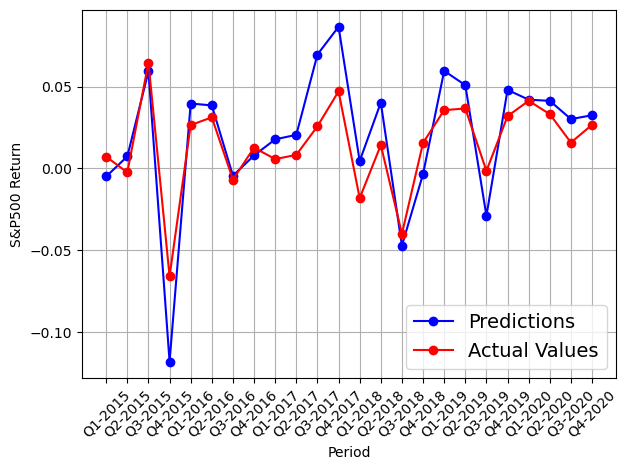

In [50]:
# Display predictions vs true values
plot_returns(Y_pred_list, Y_test_list, 'pca', best_idx=2)

Finally, we can conclude that the best tried model is given by the usage of Longformer embeddings (the ones containing the most information) together with their aggregation by quarter exploiting PCA components' aggregation. 

However, compared to the baseline linear regression, all of the used models seem to do quite well, regularly obtaining positive R-squared (i.e. prediction outperforms a simple one which only uses the average return among the test set) and relatively low mean squared errors.